# Pigment Mapping with MaxDistance and SAM

This notebook provides a step-by-step guide for mapping pigments in a hyperspectral image (HSI) using:
1) Maximum Distance (MaxD) to extract endmembers and
2) applying spectral angle mapping (SAM).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from spectral import open_image, spectral_angles
from src.MaxD_Gram import maximumDistance
from src.spectral_tools import get_band_index, make_color_image
from pathlib import Path

## Input and Output File Locations

Specify the input image file and the output file locations.

In [2]:
root_dir = Path(r'C:/Users/fzhcis/Documents/projects/from_DavidM/for_Fei/Data/Symeon/')
# root_dir = Path("/home/fzhcis/mylab/gdrive/projects_with_Dave/for_Fei/Data/Symeon")
image_file_hdr = root_dir / 'Symeon_VNIR_cropped.hdr'
outfile = root_dir / 'Symeon_VNIR_MaxD_class_map_v2.pdf'
specfile = root_dir / 'junk.pdf'
saveimages = 0 # 0: no, 1: save, 2: show

## Number of Endmembers

Specify the number of endmembers to extract and the number to keep.

In [3]:
num_EM = 15
num_to_keep = 6

## Open the Image File

Load the hyperspectral image.

In [4]:
print(f'opening image file: {image_file_hdr}')
image = open_image(image_file_hdr).load()
nrows, ncols, nbands = image.shape
print(f'IMAGE rows, cols, bands: {nrows} {ncols} {nbands}')

opening image file: C:\Users\fzhcis\Documents\projects\from_DavidM\for_Fei\Data\Symeon\Symeon_VNIR_cropped.hdr
IMAGE rows, cols, bands: 601 786 374


## Create RGB Image

Generate an RGB image from the hyperspectral data.

....> in get_band_index
<..... done

....> in get_band_index
<..... done

....> in get_band_index
<..... done



Text(0.5, 1.0, 'RGB')

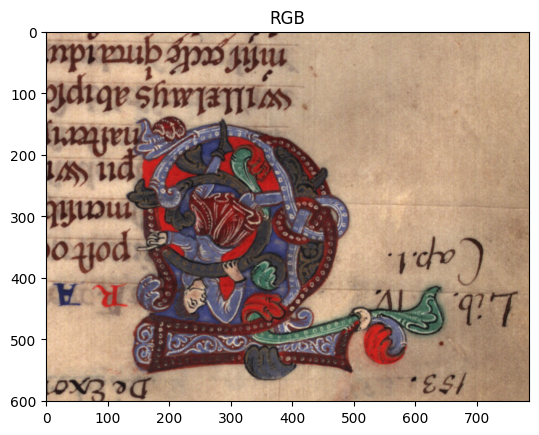

In [5]:
bands = image.bands.centers
iblue = get_band_index(bands, 475.0)
igreen = get_band_index(bands, 535.0)
ired = get_band_index(bands, 650.0)
rgbimg = make_color_image(image, ired, igreen, iblue)

plt.figure()
plt.imshow(rgbimg / np.amax(rgbimg))
plt.title('RGB')

## Extract Endmembers

Use the MaxD and Gram matrix approach to extract endmembers from the image.

Extracting 15 EMs: 
---> In MaxD extracting endmembers and Grammian ...


Text(0.5, 1.0, 'Grammian Volume Function')

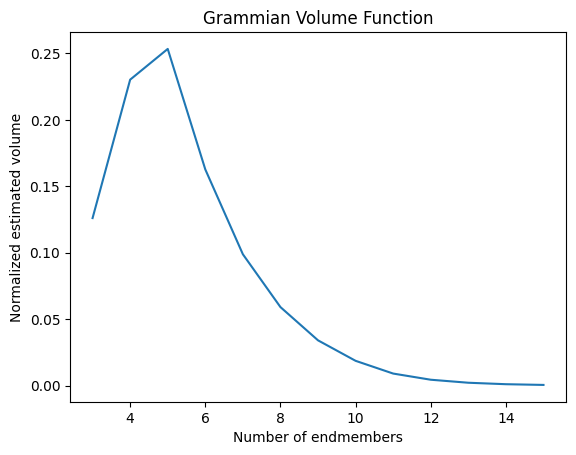

In [6]:
image2D = np.reshape(image, [nrows * ncols, nbands], order='F')
gram = 'general'
mnf_data = 0
print(f'Extracting {num_EM} EMs: ')
endmembers, endmembers_index, volume = maximumDistance(image2D, num_EM, mnf_data, gram)
volume_norm = volume / sum(volume)

x = np.arange(3, num_EM + 1)
plt.figure()
plt.plot(x, volume_norm[2:])
plt.xlabel('Number of endmembers')
plt.ylabel('Normalized estimated volume')
plt.title('Grammian Volume Function')

## Select Endmembers to Keep

Choose the number of endmembers to keep based on the volume function plot.

In [7]:
endmembers = endmembers[:, :num_to_keep]
endmembers_index = endmembers_index[:num_to_keep]

## Build Class Specification Array

Create the class specification array from the extracted endmembers.

In [8]:
class_spec = np.zeros((num_to_keep, nbands), float)
for i in range(num_to_keep):
    class_spec[i, :] = endmembers[:, i]

## Plot the Spectra Used for Classification

Set up the color map for plotting and making the class map so they match up.

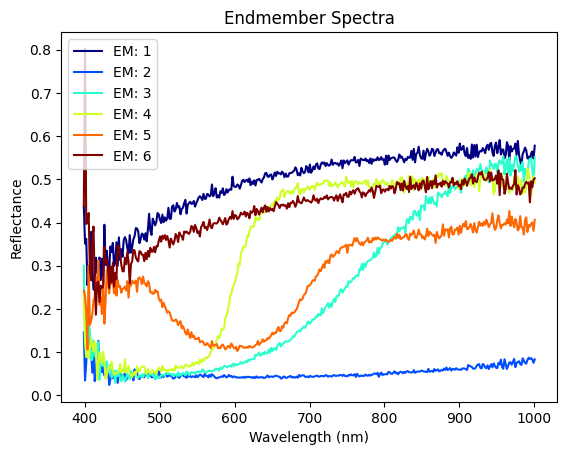

In [9]:
mycmap = plt.get_cmap('jet', num_to_keep)
newcolors = mycmap(np.arange(0, mycmap.N))
newcmp = ListedColormap(newcolors)

plt.figure()
for j in range(num_to_keep):
    EM_names = f'EM: {j + 1}'
    plt.plot(bands, class_spec[j, :], color=newcmp.colors[j], label=EM_names)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Endmember Spectra')
plt.legend(loc='best')
if saveimages == 2:
    plt.savefig(specfile, dpi=600)

## Run Spectral Angle Classification

Classify the image using spectral angle mapping with the extracted endmembers.

In [10]:
print('')
print('--> making the class map...')
angles = spectral_angles(image, class_spec)
class_map = np.argmin(angles, 2)
print('<--- done')


--> making the class map...
<--- done


## Display the Class Map

Show the class map image with the same color map as used to plot the spectra.

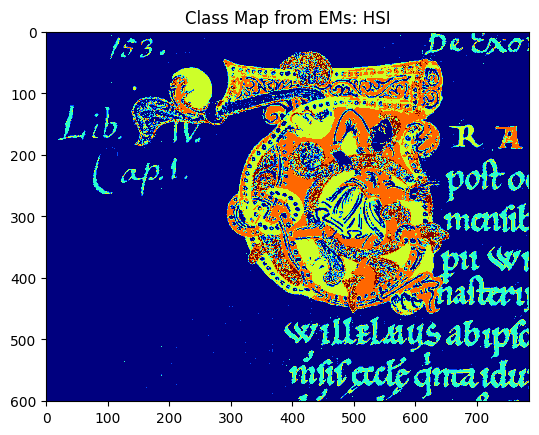

In [11]:
plt.figure()
picture = plt.imshow(np.flip(np.flip(class_map, axis=1), axis=0), cmap=newcmp)
plt.title('Class Map from EMs: HSI')
if saveimages == 1:
    plt.savefig(outfile, dpi=600)

**To do list**
- replace the import list with full-name imports
- clean up the code
- update the README.md